# <div style="color:white;display:fill;border-radius:5px;background-color:#2F4F4F;letter-spacing:0.5px;overflow:hidden\"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%\">Insiders Clustering</h1></div>

# 0.0 Imports

In [2]:
import re
import inflection
import numpy   as np
import pandas  as pd
import datetime as dt
import seaborn as sns
import umap.umap_ as umap
import matplotlib.cm as cm
from IPython.display import HTML
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn import ensemble as en
from sklearn import mixture  as mx
import scipy.cluster.hierarchy as hc


## 0.1 Helper Functions

In [81]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 16
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def numerical_metrics(num_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(num_attributes.apply(np.std)).T
    d_min = pd.DataFrame(num_attributes.apply(min)).T
    d_max = pd.DataFrame(num_attributes.apply(max)).T
    d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    #concat
    num_desc = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    num_desc.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return num_desc


def graphic_percentage(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')


In [82]:
jupyter_settings() 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['axes', 'mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [83]:
# load data
df_raw = pd.read_csv( '../data/Ecommerce.csv', encoding= 'unicode_escape' )

# 1.0 Data Description

## 1.1 Rename Columns

In [84]:
df1 = df_raw.copy()

In [85]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, df1.columns))
df1.columns = cols_new

## 1.2 Data Dimension

In [86]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 541909
Number of Columns: 9


## 1.3 Check NA

In [87]:
null_values = pd.DataFrame({'NA Count' : df1.isna().sum(), '% NA' : (df1.isna().sum()) / (df1.shape[0]) * (100)})
null_values

,NA Count,% NA
invoice_no,0,0.000000
stock_code,0,0.000000
description,1454,0.268311
quantity,0,0.000000
invoice_date,0,0.000000
unit_price,0,0.000000
customer_id,135080,24.926694
country,0,0.000000
unnamed: 8,541909,100.000000


## 1.4 Fillout NA

* O objetivo desse projeto é o agrupamento de clientes, inicialmente vamos desconsiderar todos os clientes que não foram identificados no momento da compra.

In [88]:
# drop NA column
df1 = df1.drop('unnamed: 8', axis=1)

# remove NA
df1 = df1.dropna( subset=['customer_id'] )

print( 'Removed data: {:.2f}%'.format( 1 - (df1.shape[0] / df_raw.shape[0]) ) )

Removed data: 0.25%


## 1.5 Handling Duplicates

In [89]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [90]:
# check duplicate rows
duplicate_rows = df1[df1.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['invoice_no', 'stock_code', 'description', 'customer_id', 'quantity'])
duplicate_rows_sorted.head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,29-Nov-16,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,29-Nov-16,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,29-Nov-16,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,29-Nov-16,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,29-Nov-16,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,29-Nov-16,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,29-Nov-16,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,29-Nov-16,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,29-Nov-16,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,29-Nov-16,1.65,17920.0,United Kingdom


In [91]:
print(f"The dataset contains {df1.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 5226 duplicate rows that need to be removed.


Foi identificado a presença de linhas completamente idênticas (incluindo tempos de transação idênticos), isso sugere que podem ser erros de registro ao invés de transações genuínas repetidas. Portanto, vamos remover esses registros nas etapas seguintes afim de obter um conjunto mais limpo.

## 1.6 Change dtypes

In [92]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [93]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

## 1.7 Data Descriptive

In [94]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical attributes

In [95]:
numerical_metrics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988


In [96]:
len(df1.loc[df1['unit_price'] == 0 ])

40

* quantity - quantidade mínima negativa (pode ser devolução )

* unit_price - valor unitário zerado ( pode ser brinde )

### 1.7.2 Categorical attributes

In [97]:
# invoice number - feature com string e int
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Number of invoices: {}'.format( len(df_letter_invoices) ) )
print( 'Total number of negative quantity: {}'.format( len(df_letter_invoices['quantity'] <= 0 ) ) )

Number of invoices: 8905
Total number of negative quantity: 8905


* Invoice com letras possuem quantidades negativas

In [98]:
# stock code - feature c string
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [99]:
# customer per country
cat_attributes[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


In [100]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

* Unspecified/European Community: Não há indicativo aparente de países que englobam essa categoria

# 2.0 Data Filtering

In [126]:
df2 = df1.copy()

In [127]:
df2.shape

(406829, 8)

In [128]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, : ]

# categorical attributes
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']) ]

# description/country
df2 = df2.drop(columns=['description', 'country'])

# drop duplicate
df2.drop_duplicates(inplace=True)

# bad users
# [16446, 12346, 15749]
bad_users = [17548, 16546, 15823, 13672, 12346, 13762, 16446, 17900, 18268, 14557, 16878, 13364, 14792, 12607, 12454, 18274, 12558]
df2 = df2[~df2['customer_id'].isin( bad_users )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engeneering

In [129]:
df3 = df2.copy()

In [130]:
df_ref = df3['customer_id'].drop_duplicates().reset_index(drop=True)

In [131]:
# Gross revenue
df2_purchases = df2_purchases.assign(gross_revenue=df2_purchases['quantity'] * df2_purchases['unit_price'])

In [132]:
# Invoice 
df3_invoice = df2_purchases.groupby('invoice_no').agg(  customer_id = ('customer_id', 'max'), 
                                                        invoice_date = ('invoice_date', 'max'), 
                                                        gross_revenue = ('gross_revenue', 'sum'),
                                                        unique_products = ('stock_code', 'nunique'),
                                                        items = ('quantity', 'sum') ).reset_index()

In [133]:
# Customer

last_day = df2_purchases.invoice_date.max() + dt.timedelta(days = 1)

df_customer = df3_invoice.groupby('customer_id').agg(   gross_revenue = ('gross_revenue', 'sum'),                                           
                                                        recency = ('invoice_date', lambda x: ((last_day - x.max()).days)),       
                                                        frequency = ('invoice_no', 'count'),
                                                        items = ('items', 'sum'),
                                                        products = ('unique_products', 'sum') ).reset_index()

In [134]:
df_customer.head()

,customer_id,gross_revenue,recency,frequency,items,products
0,12347,4310.00,3,7,2458,182
1,12348,1437.24,76,4,2332,23
2,12349,1457.55,19,1,630,72
3,12350,294.40,311,1,196,16
4,12352,1385.74,37,7,526,77


In [135]:
# returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity': 'returns'} )
df_returns['returns'] = df_returns['returns'] * -1


In [136]:
# merge - customer 
df_ref = pd.merge( df_ref, df_customer, on='customer_id', how='left')

# merge - returns
df_ref = pd.merge( df_ref, df_returns, on='customer_id', how='left' )
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()


customer_id       0
gross_revenue    27
recency          27
frequency        27
items            27
products         27
returns           0
dtype: int64

In [137]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
frequency        0
items            0
products         0
returns          0
dtype: int64

In [138]:
df_ref.head()

,customer_id,gross_revenue,recency,frequency,items,products,returns
0,17850,5391.21,373.0,34.0,1733.0,297.0,37.0
1,13047,3232.59,57.0,9.0,1390.0,171.0,35.0
2,12583,6705.38,3.0,15.0,5028.0,232.0,50.0
3,13748,948.25,96.0,5.0,439.0,28.0,0.0
4,15100,876.00,334.0,3.0,80.0,3.0,22.0


# 4.0 EDA (Exploratory Data Analysis)

In [139]:
df4 = df_ref.copy()

In [140]:
# profile = ProfileReport( df4 )
# profile.to_file( 'output.html' )

##  4.1 Univariate Analysis

### 4.1.1 Bad Values

In [116]:
# bad users - 
df_aux = df4.copy()
df_aux['perc_returns'] = (df4['returns'] / df4['items']) * 100
bad_users = df_aux.loc[df_aux['perc_returns'] >= 98 ]
bad_users.sort_values(['perc_returns'], ascending=False)


,customer_id,gross_revenue,recency,frequency,items,products,returns,perc_returns
159,15823,15.00,373.0,1.0,1.0,1.0,282.0,28200.000000
16,17548,103.30,234.0,1.0,58.0,5.0,190.0,327.586207
125,16546,787.15,291.0,2.0,549.0,25.0,852.0,155.191257
3479,16878,13.30,85.0,1.0,12.0,3.0,12.0,100.000000
4110,18274,175.92,31.0,1.0,88.0,11.0,88.0,100.000000
3815,12454,3528.34,57.0,1.0,1006.0,15.0,1006.0,100.000000
3770,12607,1579.51,61.0,1.0,1228.0,101.0,1228.0,100.000000
3717,14792,6.20,64.0,1.0,2.0,2.0,2.0,100.000000
3634,13364,134.96,72.0,1.0,71.0,10.0,71.0,100.000000
3155,18268,25.50,135.0,1.0,2.0,1.0,2.0,100.000000


* Após analisar as features individualmente, foi observado que alguns clientes tiveram compras seguidas de cancelamento, alguns até com número maior de devoluções em relação as compras efetuadas. Diante disso, estaremos desconsiderando-os neste ciclo. 

    ID -> [17548, 16546, 15823, 13672, 12346, 13762, 16446, 17900, 18268, 14557, 16878, 13364, 14792, 12607, 12454, 18274, 12558]

## 4.2 Bivariate Analysis

In [141]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 1800x864 with 0 Axes>

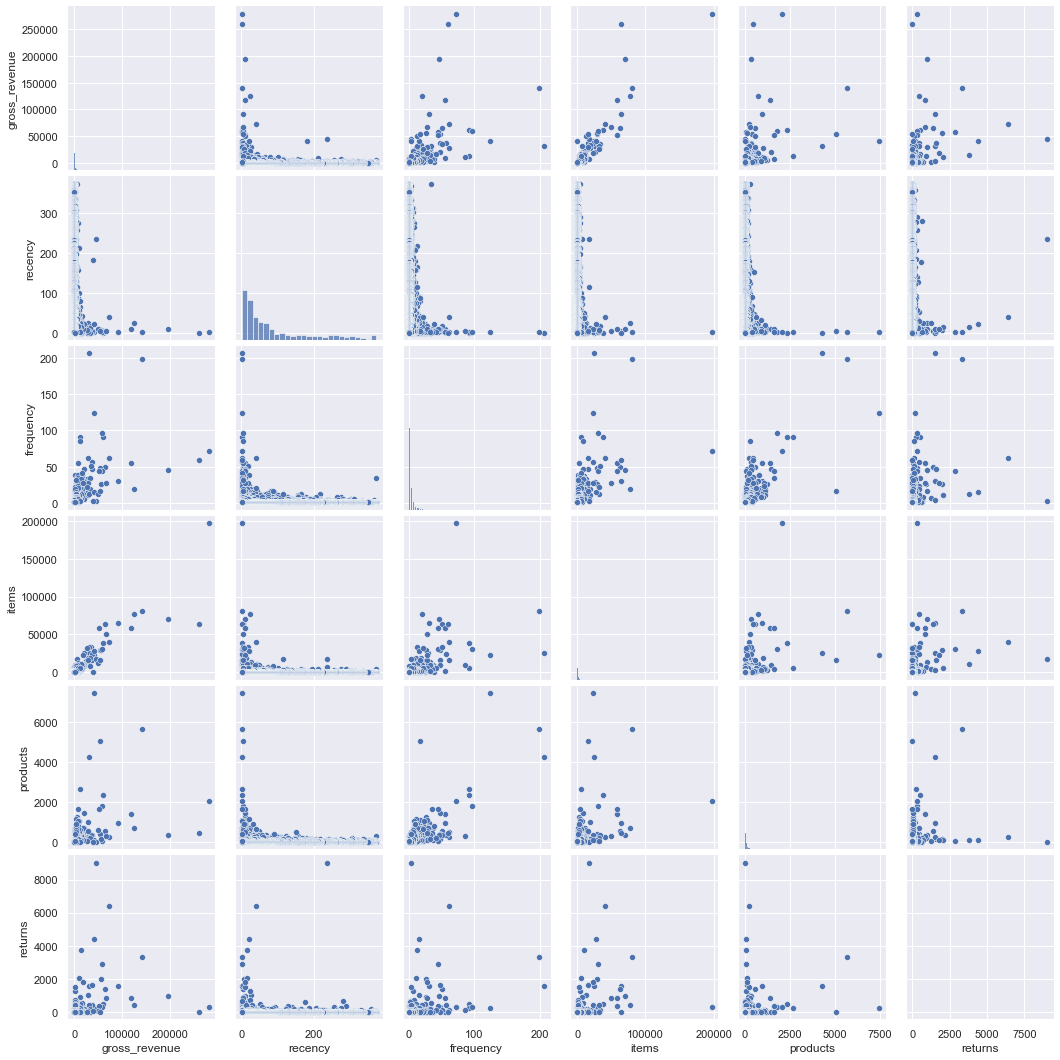

In [142]:
plt.figure( figsize=(25,12) )
sns.pairplot( df42 );

## 4.3 Cohort Analysis

* Análise Cohort é uma métrica utilizada para analisar como diferentes grupos de clientes se comportam ao longo do tempo. Ajuda compreender se o envolvimento do usuário está realmente melhorando com o tempo ou apenas parece melhorar devido ao crescimento. 

In [143]:
print("Min date: {} \nMax date: {}".format(df3.invoice_date.min(), df3.invoice_date.max()))
print("Time difference is: {}".format(df3.invoice_date.max() - df3.invoice_date.min()))

Min date: 2016-11-29 00:00:00 
Max date: 2017-12-07 00:00:00
Time difference is: 373 days 00:00:00


In [144]:
def get_month(x): 
    return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [145]:
df3["invoice_month"] = df3["invoice_date"].apply(get_month)
df3["cohort_month"] = df3.groupby("customer_id")["invoice_month"].transform("min")

In [146]:
invoice_year, invoice_month, _ = get_dates(df3, "invoice_month")
cohort_year, cohort_month, _ = get_dates(df3, "cohort_month")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df3["cohort_index"] = 12 * year_diff + month_diff + + 1

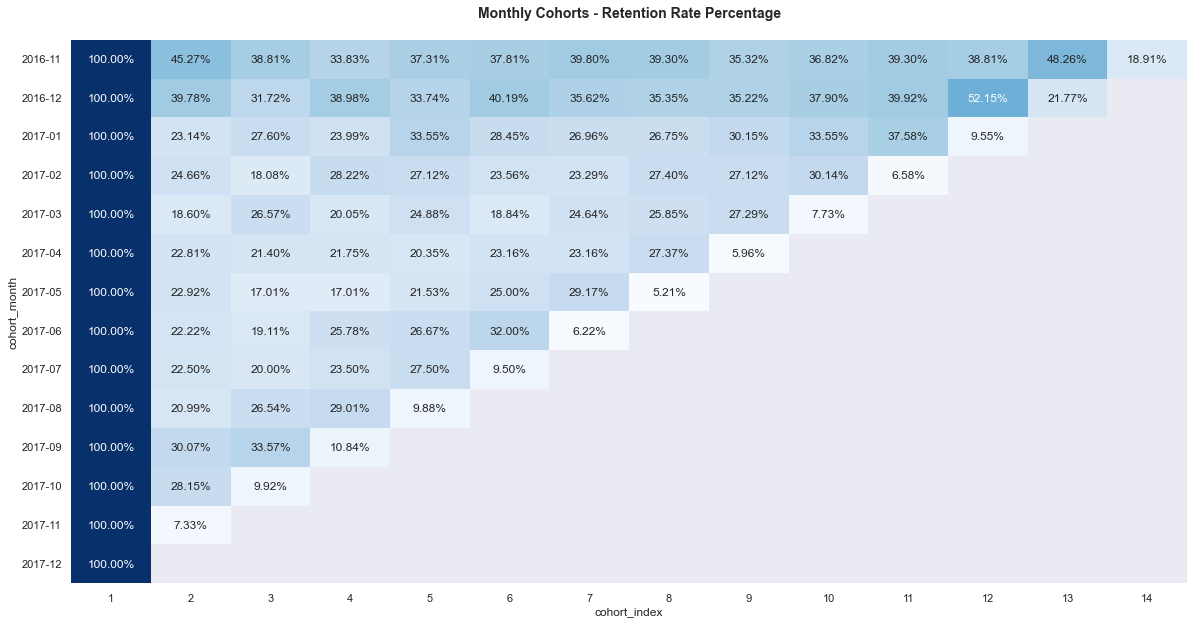

In [147]:
cohort_data = df3.groupby(['cohort_index', 'cohort_month'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot_table(index='cohort_month', columns='cohort_index', values='customer_id')
cohort_pivot.index = cohort_pivot.index.strftime('%Y-%m')

cohort_sizes = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_sizes, axis=0)

# plot 
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(retention, cmap='Blues', annot=True, fmt='.2%', annot_kws={'fontsize': 12}, cbar=False, ax=ax)
plt.title('Monthly Cohorts - Retention Rate Percentage\n', fontsize=14, fontweight='bold');

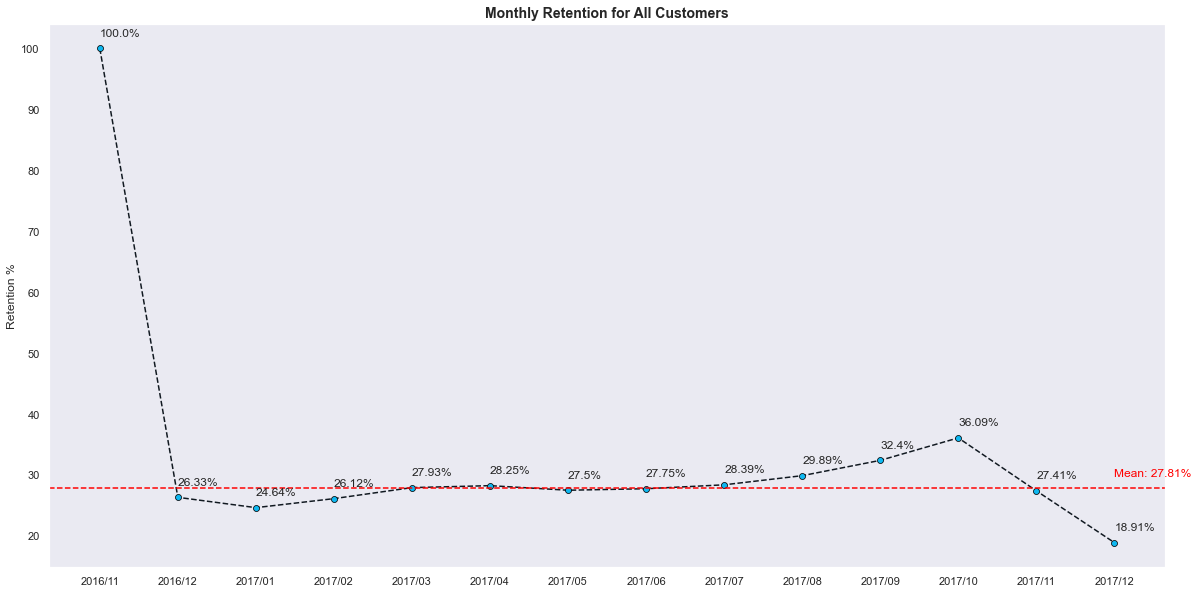

In [148]:
# unique customers per month
customer_per_month = df3.groupby("cohort_month")["customer_id"].nunique()
customer_per_month.index = customer_per_month.index.strftime('%Y/%m')

# cumulative sum of customers
customers = customer_per_month.cumsum().sort_index(ascending=False)

# unique customers in month
customer_in_month = df3.groupby("cohort_index")["customer_id"].nunique()
customer_in_month.index=customer_per_month.index #Inverted

# plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.grid(False)
x = customer_in_month.index
y = 100 * (customer_in_month / customers.values)
avg_retention = y[1:].mean()
sns.lineplot(x=x, y=y, color="#101820", linestyle="--", marker="o", markerfacecolor="#0EB8F1", markeredgecolor="#000000")
for i, (xi, yi) in enumerate(zip(x, y)):
    ax.annotate(f"{round(yi, 2)}%", (xi, yi + 2))
plt.axhline(y=avg_retention, color='red', linestyle='--')
plt.text(x[-1], avg_retention + 2, f'Mean: {round(avg_retention, 2)}%', color='red', ha='left')
plt.xlabel("")
plt.ylabel("Retention %")
plt.title("Monthly Retention for All Customers", fontsize=14, fontweight='bold')
plt.show()

Observamos que a taxa de retenção se manteve na média ao longo dos meses tendo uma alta entre os meses de setembro a novembro. Podemos analisar em outro ciclo o que levou a esse aumento, possíveis datas comemorativas de final de ano podem ter influenciado o aumento nesses meses.

# 5.0 Feature Selection

In [149]:
# selected dataset
cols_selected = ['gross_revenue', 'recency', 'frequency', 'products', 'returns' ]
df5 = df4[cols_selected].copy()

# 6.0 Data Preparation

In [150]:
df6 = df5.copy()

In [151]:
mm = pp.MinMaxScaler()


df6['gross_revenue'] = mm.fit_transform( df6[['gross_revenue']] )
df6['recency']  =      mm.fit_transform( df6[['recency']] )
df6['frequency'] =     mm.fit_transform( df6[['frequency']] )
df6['products'] =      mm.fit_transform( df6[['products']] )
df6['returns'] =       mm.fit_transform( df6[['returns']] )

X = df6.copy()

## 6.1 Dimensonality Reduction

### 6.1.1 PCA

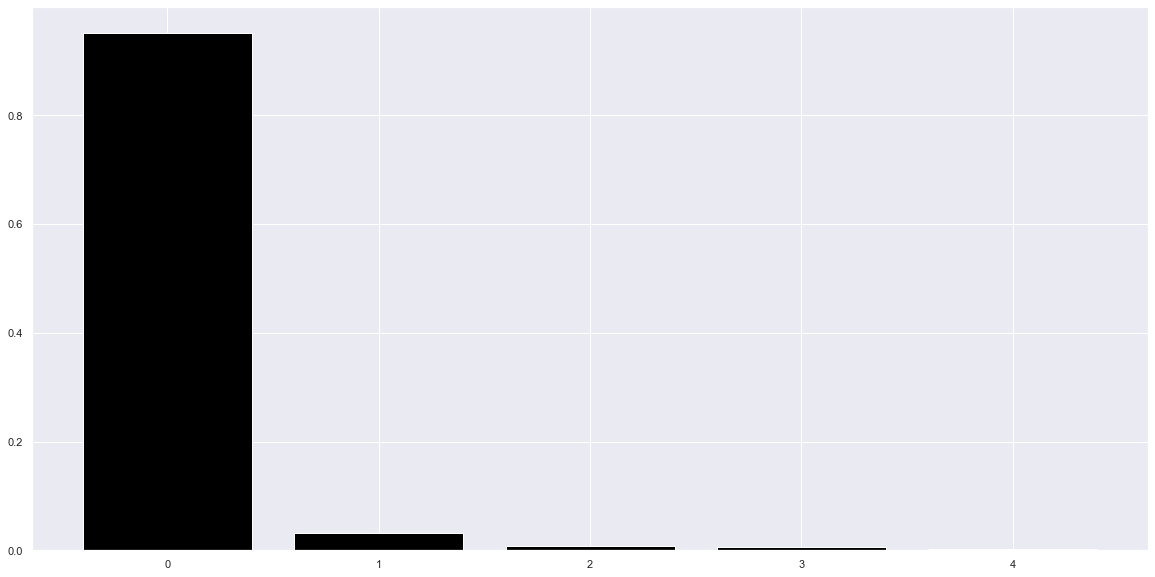

In [152]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

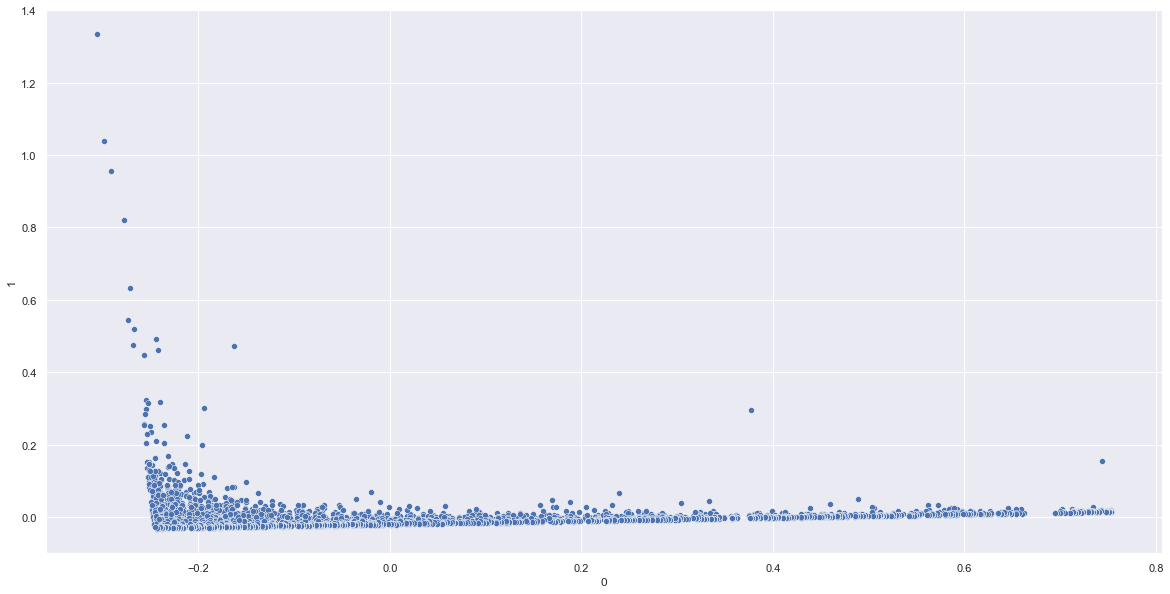

In [153]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 6.1.2 UMAP

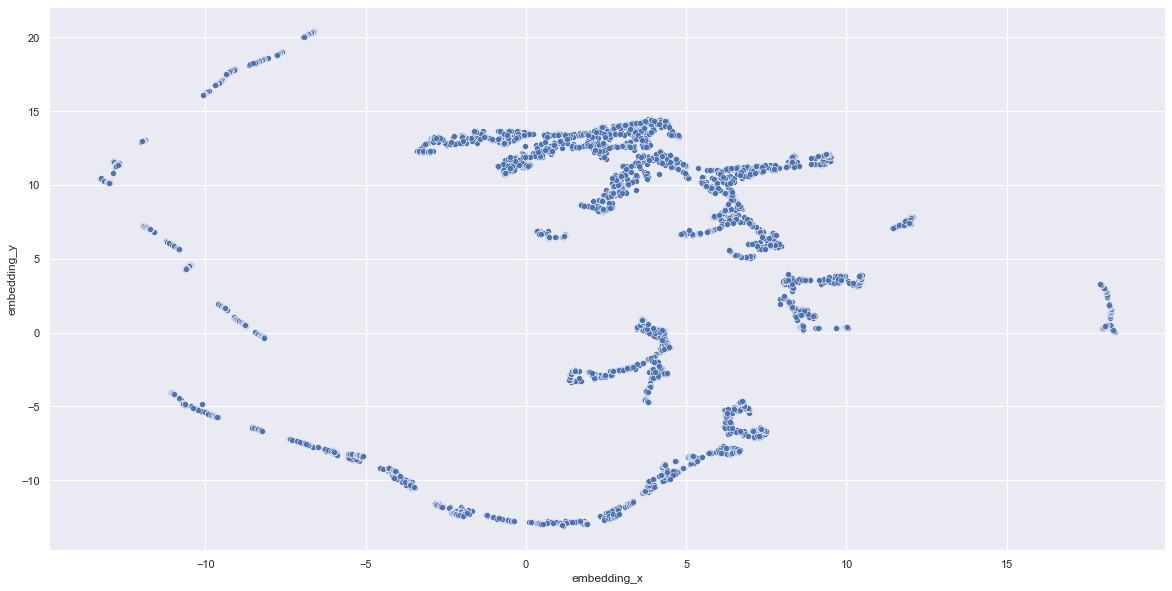

In [154]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap );

### 6.1.3 - T-SNE

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


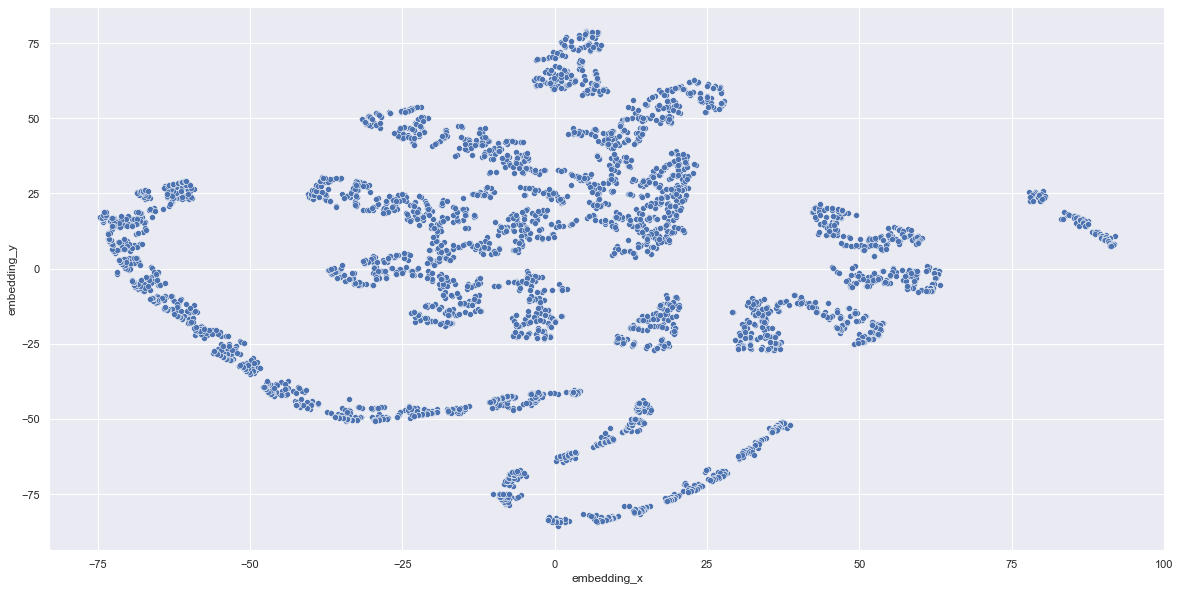

In [155]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne );

### 6.1.4 Tree-based Embedding

In [156]:
# training dataset
X = df6.drop( columns=['gross_revenue'], axis=1 )

# defining target
y = df6['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, min_samples_split=32, n_jobs=-1, random_state=42 )

# model training
rf_model.fit( X, y )

# leafs
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [157]:
X.shape, df_leaf.shape

((4318, 4), (4318, 100))

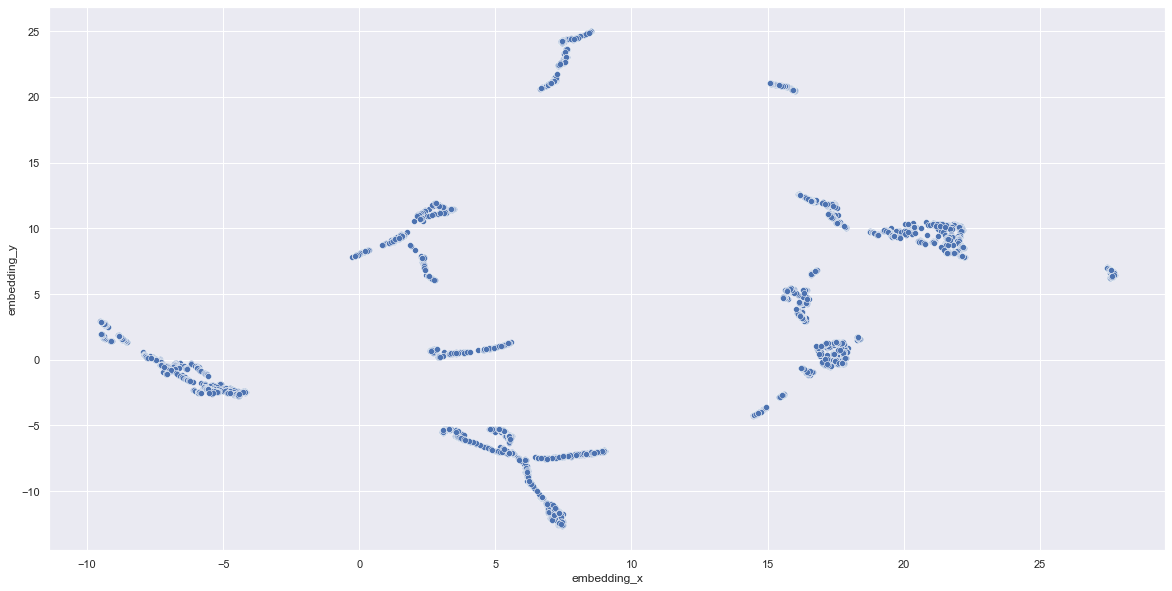

In [158]:
# reduce dimensionality
reducer = umap.UMAP( n_neighbors=100, random_state=42, metric='euclidean') 
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tree );

# 7.0  Hyperparameter Fine Tunning

In [159]:
X = df_tree.copy()

In [160]:
clusters = np.arange( 2, 16 ,1)

## 7.1 Models

In [161]:
kmeans_list = []
gmm_list = []
hc_list = []

for k in clusters:
    
    # kmeans
    kmeans_model = c.KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans_labels = kmeans_model.fit_predict(X)
    kmeans_sil = m.silhouette_score(X, kmeans_labels, metric='euclidean')
    kmeans_list.append(kmeans_sil)

    # GMM
    gmm_model = mx.GaussianMixture(n_components=k, n_init=100, random_state=42)
    gmm_labels = gmm_model.fit_predict(X)    
    gmm_sil = m.silhouette_score(X, gmm_labels, metric='euclidean')
    gmm_list.append(gmm_sil)

    # HC
    hc_model = hc.linkage( X, 'ward' )
    hc_labels = hc.fcluster( hc_model, k, criterion='maxclust' )
    hc_sil = m.silhouette_score(X, hc_labels, metric='euclidean')
    hc_list.append(hc_sil)     

In [162]:
dbs_list = []
eps = np.arange(1, 2.5, 0.11)

for k in eps:
    dbs_model = c.DBSCAN(eps=k, min_samples=20, metric='euclidean')
    dbs_labels = dbs_model.fit_predict(X)   
    dbs_sil = m.silhouette_score(X, dbs_labels, metric='euclidean')
    dbs_list.append(dbs_sil) 

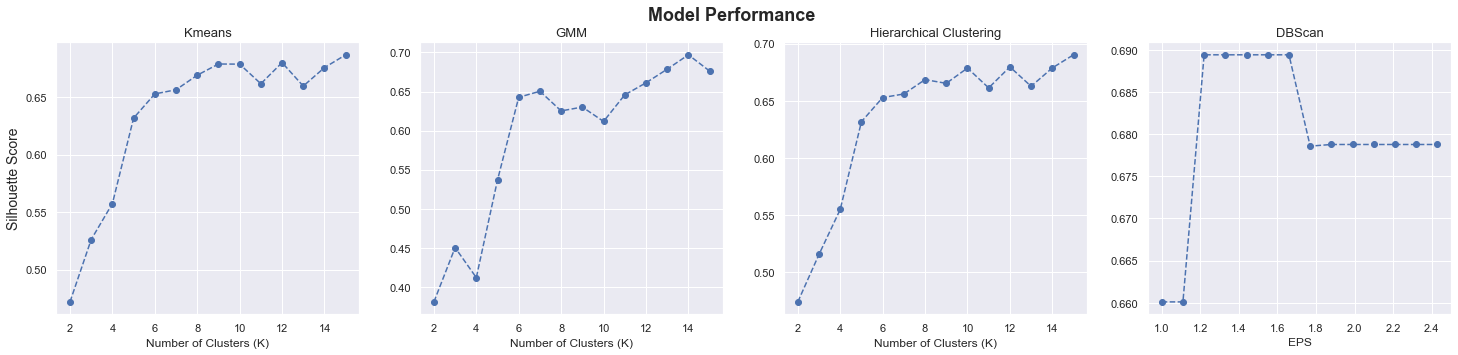

In [163]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
fig.suptitle("Model Performance\n\n", fontweight='bold', fontsize=18)

axes[0].plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
axes[0].set_title("Kmeans", fontsize=13)
axes[0].set_ylabel('Silhouette Score', fontsize=14)
axes[0].set_xlabel('Number of Clusters (K)')

axes[1].plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
axes[1].set_title("GMM", fontsize=13)
axes[1].set_xlabel('Number of Clusters (K)')

axes[2].plot(clusters, hc_list, linestyle='--', marker='o', color='b')
axes[2].set_title("Hierarchical Clustering", fontsize=13)
axes[2].set_xlabel('Number of Clusters (K)')

axes[3].plot(eps, dbs_list, linestyle='--', marker='o', color='b')
axes[3].set_title("DBScan", fontsize=13)
axes[3].set_xlabel('EPS')

plt.show()

## 7.2 Results

In [164]:
df_results = pd.DataFrame( {'KMeans': kmeans_list, 
                            'GMM': gmm_list,
                            'HC': hc_list,
                            'DBSCAN': dbs_list }).T
df_results.columns = clusters
df_results.style.highlight_max( color='green', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15
KMeans,0.471875,0.526095,0.557351,0.631694,0.652671,0.656309,0.668944,0.678692,0.678576,0.661529,0.679908,0.659515,0.675548,0.686689
GMM,0.380955,0.450412,0.412029,0.536929,0.642697,0.650390,0.625264,0.630200,0.611796,0.645802,0.661176,0.678642,0.697028,0.676298
HC,0.474153,0.515695,0.554989,0.631675,0.652797,0.655933,0.668482,0.665218,0.678576,0.661239,0.679618,0.662652,0.678680,0.690170
DBSCAN,0.660106,0.660106,0.689405,0.689405,0.689405,0.689405,0.689405,0.678576,0.678771,0.678771,0.678771,0.678771,0.678771,0.678771


## 7.3 Silhouette Analysis

### 7.3.1 Hierarchical Clustering

 For K = 2. Silhouette Score: 0.4741532504558563
 For K = 3. Silhouette Score: 0.5156949162483215
 For K = 4. Silhouette Score: 0.5549893379211426
 For K = 5. Silhouette Score: 0.6316748857498169
 For K = 6. Silhouette Score: 0.6527974009513855
 For K = 7. Silhouette Score: 0.6559328436851501
 For K = 8. Silhouette Score: 0.668481707572937
 For K = 9. Silhouette Score: 0.66521817445755
 For K = 10. Silhouette Score: 0.6785763502120972
 For K = 11. Silhouette Score: 0.6612386703491211
 For K = 12. Silhouette Score: 0.6796184182167053
 For K = 13. Silhouette Score: 0.662651538848877
 For K = 14. Silhouette Score: 0.6786795258522034
 For K = 15. Silhouette Score: 0.6901698112487793


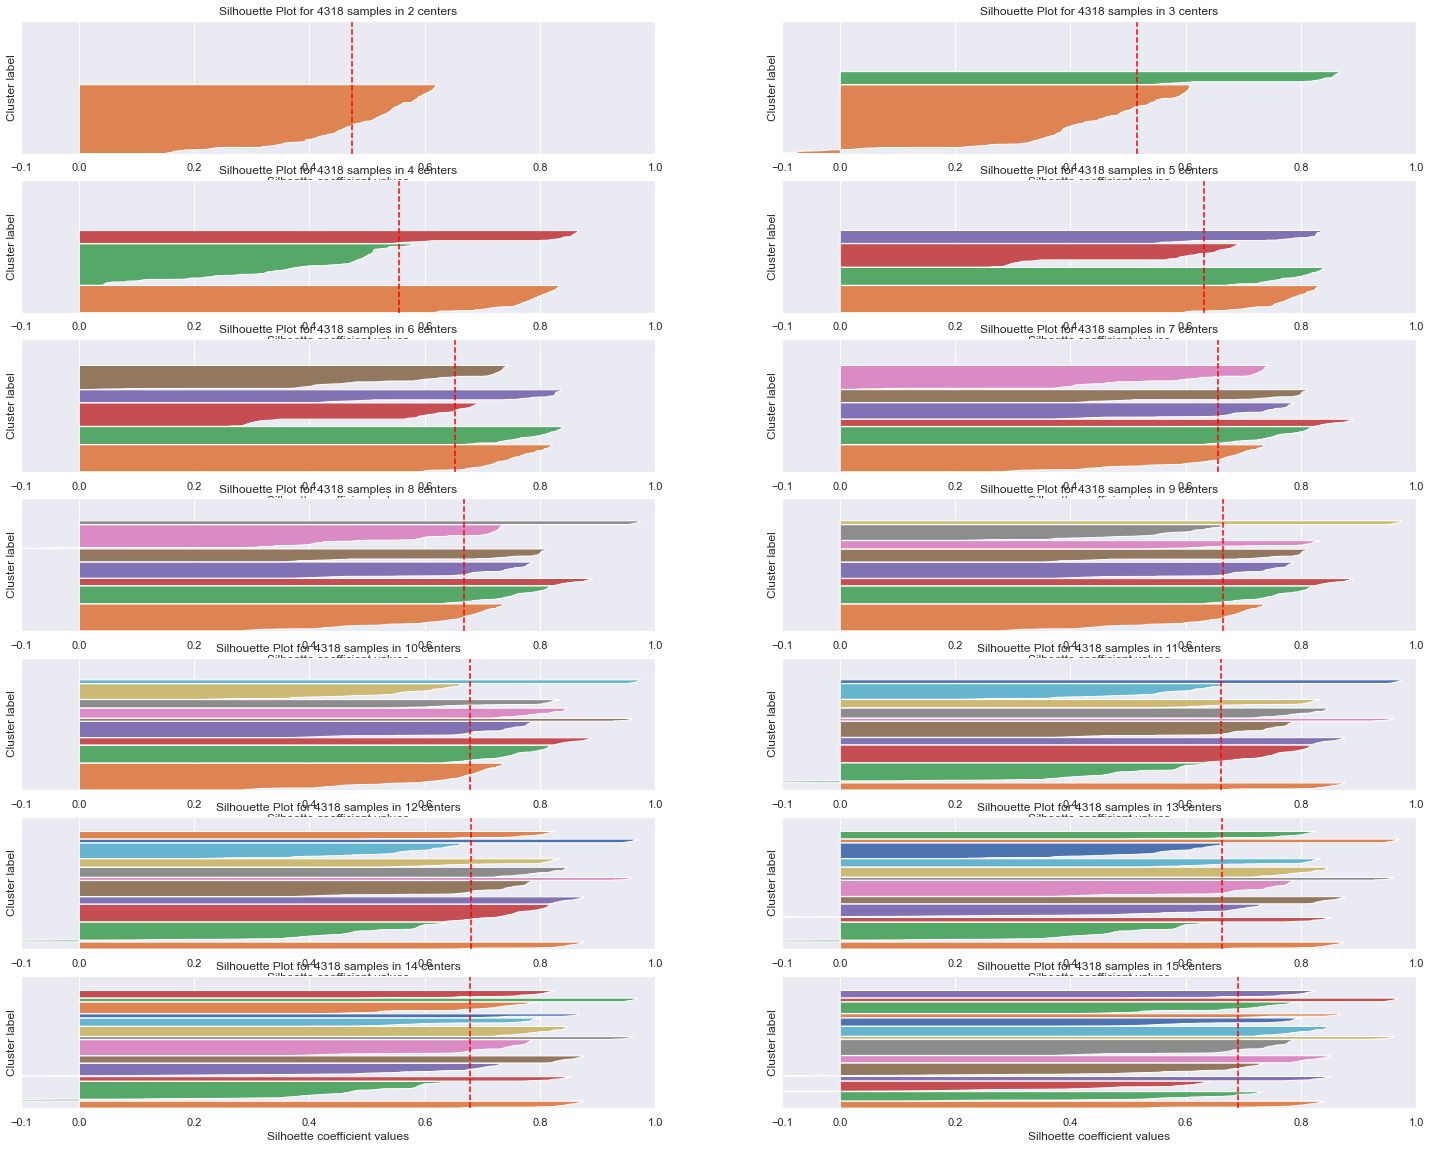

In [165]:
fig, ax = plt.subplots( 7, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )
    
    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )
    

    # performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, sil ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )
    
    ax[q-1, mod].axvline(x=sil, color="red", linestyle="--", label="Avarage Silhouette Score")
    ax[q-1, mod].set_title('Silhouette Plot for {} samples in {} centers' .format(X.shape[0], k ) )
    ax[q-1, mod].set_xlabel('Silhoette coefficient values')
    ax[q-1, mod].set_ylabel('Cluster label')

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # color
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )
        
        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )

        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 7.3.2 DBSCAN

Avarage Silhouette Score: 0.6894046664237976


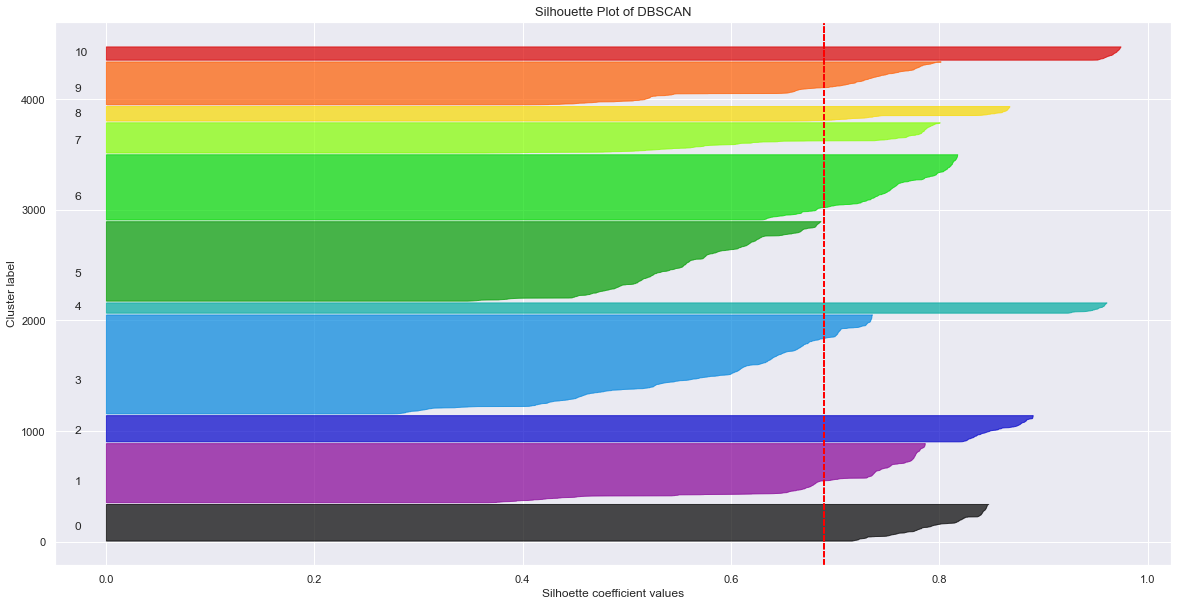

In [166]:
# model
dbscan = c.DBSCAN(eps=1.3, min_samples=20)

# predict
labels = dbscan.fit_predict(X)

# avarage silhouette score
sil_avg = m.silhouette_score(X, labels)
print(f'Avarage Silhouette Score: {sil_avg}')

# 
sample_silhouette_values = m.silhouette_samples(X, labels)

# plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(max(labels) + 1):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / (max(labels) + 1))

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.axvline(x=sil_avg, color="red", linestyle="--", label="Avarage Silhouette Score")
    
    # centralizar rotulo
    ax.text(-0.03, y_lower + 0.3 * size_cluster_i, str(i))
    
    # separação
    y_lower = y_upper + 15

ax.set_title('Silhouette Plot of DBSCAN', fontsize=13 )
ax.set_xlabel("Silhoette coefficient values")
ax.set_ylabel('Cluster label')
plt.show()

# 8.0  Model Training

In [167]:
dbs_model = c.DBSCAN(eps=1.3, min_samples=20, metric='euclidean')
dbs_labels = dbs_model.fit_predict(X)   
print( 'SS value: {}'.format( m.silhouette_score( X, dbs_labels, metric='euclidean' ) ) )

SS value: 0.6894046664237976


# 9.0 Cluster Analysis

In [168]:
df9 = X.copy()
#df9 = df4.copy()
df9['cluster'] = dbs_labels
df9.head()

,embedding_x,embedding_y,cluster
0,7.468872,24.347242,0
1,3.178928,11.180243,1
2,7.493805,22.881407,0
3,5.473876,1.241869,2
4,7.311502,-12.515188,3


## 9.1. Visualization Inspection

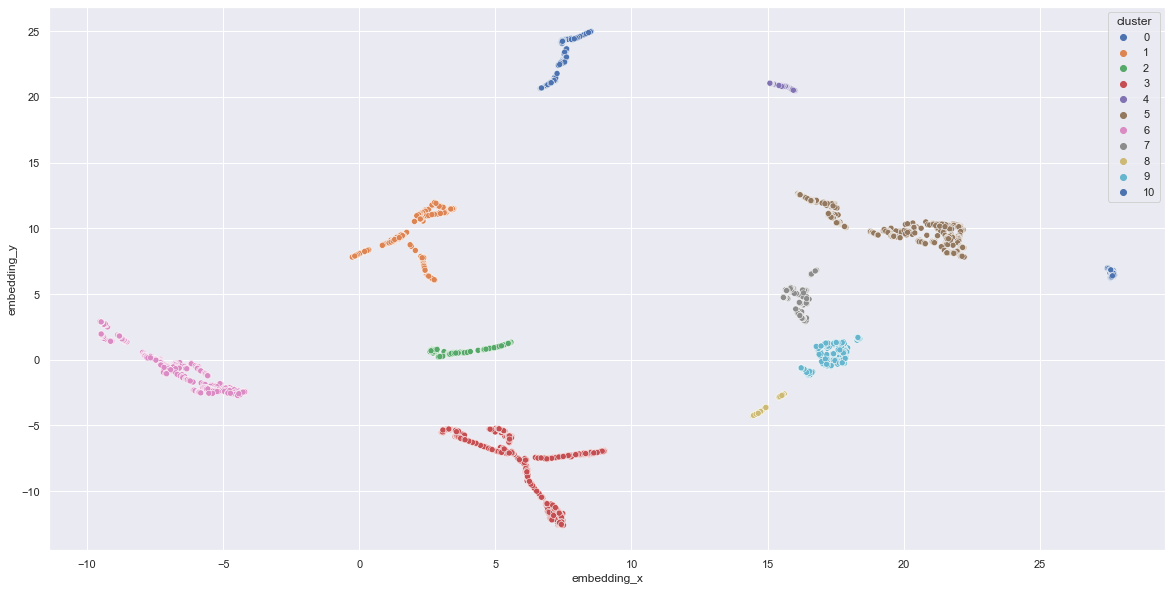

In [169]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

## 9.2 Cluster profile

In [170]:
df92 = df4.copy()
df92['cluster'] = dbs_labels
df92.head()

,customer_id,gross_revenue,recency,frequency,items,products,returns,cluster
0,17850,5391.21,373.0,34.0,1733.0,297.0,37.0,0
1,13047,3232.59,57.0,9.0,1390.0,171.0,35.0,1
2,12583,6705.38,3.0,15.0,5028.0,232.0,50.0,0
3,13748,948.25,96.0,5.0,439.0,28.0,0.0,2
4,15100,876.00,334.0,3.0,80.0,3.0,22.0,3


In [171]:
df_cluster = df92.groupby('cluster').agg({  'customer_id': 'count',
                                            'gross_revenue': 'mean',
                                            'recency': 'mean',
                                            'frequency': 'mean',
                                            'items': 'mean',
                                            'products': 'mean',
                                            'returns': 'mean'}).reset_index()

df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)
df_cluster

,cluster,customer_id,gross_revenue,recency,frequency,items,products,returns,perc_customer
0,0,332,12935.542500,16.123494,21.141566,7356.325301,412.237952,162.641566,7.688745
1,1,535,2867.133215,32.596262,7.413084,1751.364486,162.700935,42.600000,12.389995
2,2,238,1767.367731,42.651261,4.995798,1046.273109,109.432773,21.453782,5.511811
3,3,895,1282.074883,62.701676,3.437989,758.170950,77.044693,8.404469,20.727189
8,8,132,1239.300530,85.462121,1.787879,783.825758,115.045455,5.310606,3.056971
9,9,388,759.644381,85.556701,1.912371,463.987113,49.536082,6.912371,8.985642
7,7,274,505.135182,132.667883,1.000000,305.602190,42.777372,0.832117,6.345530
5,5,719,411.098345,138.488178,1.343533,257.237830,21.133519,4.566064,16.651227
10,10,121,376.061736,114.256198,2.000000,217.950413,7.512397,3.611570,2.802223
4,4,94,292.061702,173.723404,1.000000,186.212766,13.468085,1.053191,2.176934


In [172]:
def cluster_label(x):
    cluster_labels = {
        0: 'Insiders',
        1: 'Loyal Customers',
        2: 'Potentials',
        3: 'Promising',
        8: 'Regular',
        9: 'Need Attention',
        7: 'At Risk',
        5: 'Sleeping',
        10: 'Hibernating',
        4: 'About to lose',
        6: 'Losing'
    }
    return cluster_labels.get(x)

df_cluster['cluster'] = df_cluster['cluster'].apply(cluster_label)
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,gross_revenue,recency,frequency,items,products,returns,perc_customer
0,Insiders,332,12935.542500,16.123494,21.141566,7356.325301,412.237952,162.641566,7.688745
1,Loyal Customers,535,2867.133215,32.596262,7.413084,1751.364486,162.700935,42.600000,12.389995
2,Potentials,238,1767.367731,42.651261,4.995798,1046.273109,109.432773,21.453782,5.511811
3,Promising,895,1282.074883,62.701676,3.437989,758.170950,77.044693,8.404469,20.727189
8,Regular,132,1239.300530,85.462121,1.787879,783.825758,115.045455,5.310606,3.056971
9,Need Attention,388,759.644381,85.556701,1.912371,463.987113,49.536082,6.912371,8.985642
7,At Risk,274,505.135182,132.667883,1.000000,305.602190,42.777372,0.832117,6.345530
5,Sleeping,719,411.098345,138.488178,1.343533,257.237830,21.133519,4.566064,16.651227
10,Hibernating,121,376.061736,114.256198,2.000000,217.950413,7.512397,3.611570,2.802223
4,About to lose,94,292.061702,173.723404,1.000000,186.212766,13.468085,1.053191,2.176934


## 9.3 Business questions

In [173]:
df93 = df92.copy()
df93['cluster'] = df93['cluster'].apply(cluster_label)

**1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

In [174]:
insiders = df93.loc[df93['cluster'] == 'Insiders', 'customer_id']
insiders.head()

0    17850
2    12583
5    15291
6    14688
7    17809
Name: customer_id, dtype: int32

**2. Quantos clientes farão parte do grupo?**


In [175]:
print('O grupo Insiders é composto de {} clientes'.format(len(insiders)))

O grupo Insiders é composto de 332 clientes


**3. Quais as principais características desses clientes?**

- Número de clientes: 332 (7,7% dos clientes)
- Receita média: €12.935,54
- Recência em média: 16 dias
- Quantidade média de itens comprados: 7356
- Frequência de compra: 21
- Quantidade média de produtos retornados: 162

In [176]:
df_cluster[df_cluster['cluster'] == 'Insiders']

,cluster,customer_id,gross_revenue,recency,frequency,items,products,returns,perc_customer
0,Insiders,332,12935.5425,16.123494,21.141566,7356.325301,412.237952,162.641566,7.688745


**4. Qual a porcentagem de contribuição do faturamento, vinda dos Insiders?**

A receita proveniente do grupo Insider representa 50,6% do faturamento total

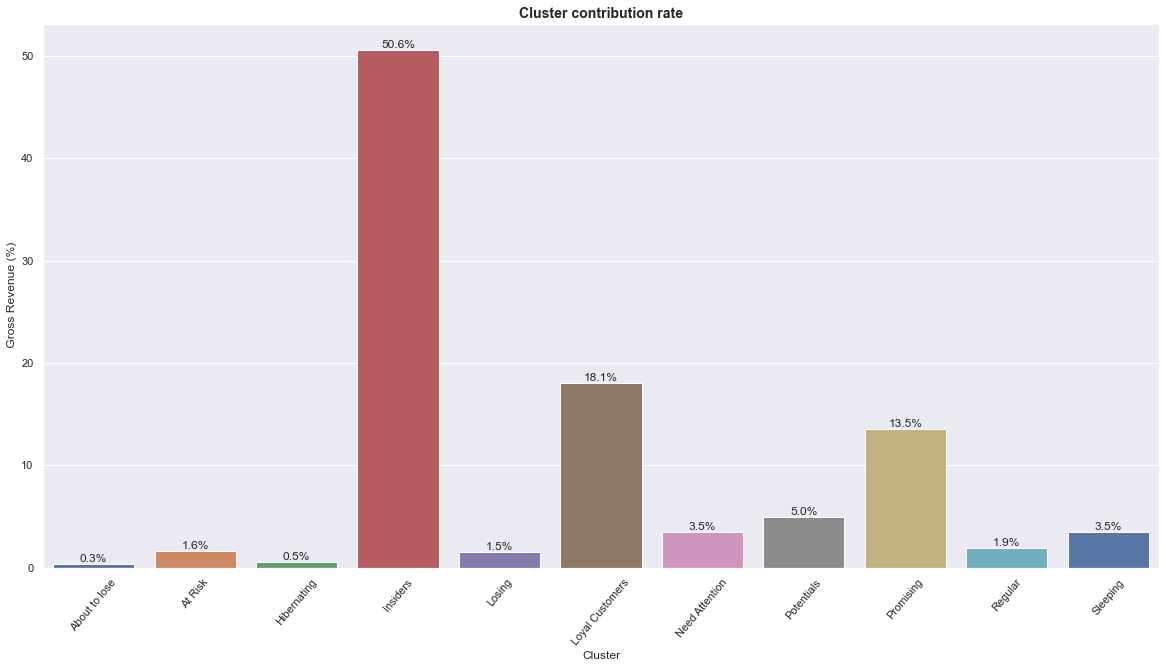

In [177]:
aux1 = df93.groupby(['cluster'])['gross_revenue'].sum().reset_index()
aux1['percentage'] = (aux1['gross_revenue'] / aux1['gross_revenue'].sum()) * 100

ax = sns.barplot(y='percentage', x='cluster', data=aux1, palette='deep')
plt.xlabel('Cluster')
plt.ylabel(' Gross Revenue (%)')
plt.title('Cluster contribution rate', fontweight='bold', fontsize=14)
plt.xticks(rotation=50);

graphic_percentage(ax)

**5. Qual a expectativa de faturamento desse grupo para os próximos meses?**

Precisamos entender o comportamento deste grupo ao longo dos próximos meses. Com esses novos dados podemos utilizar séries temporais para responder esta pergunta de négocio.

**6. Quais as condições para uma pessoa ser elegível ao Insiders ? E para ser removida ?**

Será necessário o monitoramento do cluster ao longo do tempo. Em uma análise inicial podemos constatar que para ser elegível ao grupo é necessário um alto valor de compra, alta frequência e baixa recência.

**7. Qual a garantia que o programa Insiders é melhor que o restante da base?**

Conforme evidências destacadas acima o cluster **Insiders** representa 50,6% do faturamento total contendo apenas 7,7% do total de clientes cadastrados.

**9. Quais ações o time de marketing pode realizar para aumentar o faturamento?**

**Insiders:** Ações para reduzir o número de devoluções e manter a frequência de compra.

**Loyal Customers / Potentials / Promissing:** Ações para aumentar o número de items comprados ( cross-sell )

**Regular / Need Attention / At Risk:** Reduzir a recência ( promoções personalizadas, sistemas de recomendação )

**Sleeping / Hibernating / About to lose / Losting:** Campanhas para recuperar esses grupos (cupons de desconto)